## Get the electricity data for the past three days

In [3]:
import requests as rq
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [4]:
pred_start = datetime(2019,10,14,0,5,0)
pred_end = datetime(2019,10,19,0,5,0)
start_day = 0
end_day = 5

In [5]:
# Current time
# now = datetime.now()
now = pred_end-timedelta(days=1)
# Time three days ago
three_days_ago = pred_start-timedelta(days=3)

In [6]:
end = now.strftime('%Y%m%dT%H-%M')
start = three_days_ago.strftime('%Y%m%dT%H-%M')
key = '8a6315646d5695061696c71a041c42c0'
series_id = 'EBA.TEX-ALL.NG.HL'
data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, start, end))

In [7]:
usage_series_id = 'EBA.TEX-ALL.D.HL'
usage_data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, usage_series_id, start, end))

In [8]:
hourly_demand = data.json()['series'][0]['data']
electricity_demand = pd.DataFrame(hourly_demand, columns=['datetime','net_gen'])
electricity_usage = pd.DataFrame(usage_data.json()['series'][0]['data'], columns=['datetime', 'usage'])
electricity_demand = electricity_demand.merge(electricity_usage, how='right', left_on='datetime', right_on='datetime')
electricity_demand = electricity_demand.sort_values(['datetime']).reset_index(drop=True)

In [9]:
electricity_demand.head(5)

,datetime,net_gen,usage
0,20191011T00-05,43796,43833
1,20191011T01-05,40703,40775
2,20191011T02-05,38475,38687
3,20191011T03-05,36931,37148
4,20191011T04-05,35915,36132


In [10]:
electricity_demand.tail(1)

,datetime,net_gen,usage
168,20191018T00-05,32712,32534


In [11]:
def diff_in_hours(x):
    # This function returns the number of hours from 2015-07-01 01:05:00
    minutes = (x-datetime(2015, 7, 1, 1, 5, 0)).total_seconds()/60
    if minutes % 60 > 30:
        return minutes/60 + 1
    else:
        return minutes/60
    
df_for_periodic_model = electricity_demand.copy()
df_for_periodic_model['datetime'] = pd.to_datetime(df_for_periodic_model['datetime'], format='%Y%m%dT%H-%M')
df_for_periodic_model['hours'] = df_for_periodic_model['datetime'].apply(lambda x: diff_in_hours(x))

# Construct the sin and cos columns.
def trig(func, period, x):
    # This function returns a sin or x value of x.
    return func(2*np.pi*x/period)

# Yearly period.
df_for_periodic_model['yearly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24, x))
df_for_periodic_model['yearly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24, x))
df_for_periodic_model['yearly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/2, x)) # Starting from here are harmonics
df_for_periodic_model['yearly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/2, x))
df_for_periodic_model['yearly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/3, x))
df_for_periodic_model['yearly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/3, x))
# Weekly period.
df_for_periodic_model['weekly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24, x))
df_for_periodic_model['weekly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24, x))
df_for_periodic_model['weekly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24/2, x))
df_for_periodic_model['weekly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24/2, x))
# Dayly period.
df_for_periodic_model['dayly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24, x))
df_for_periodic_model['dayly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24, x))
df_for_periodic_model['dayly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/2, x))
df_for_periodic_model['dayly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/2, x))
df_for_periodic_model['dayly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/3, x))
df_for_periodic_model['dayly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/3, x))
df_for_periodic_model['dayly_4_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/4, x))
df_for_periodic_model['dayly_4_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/4, x))

# Produce the x^2 and X^3 term for the ridge regressor

df_for_periodic_model['scaled_hours'] = df_for_periodic_model['hours']/100

In [12]:
def trend(linear_trend, row):
    return (row*linear_trend.coef_[0]+linear_trend.intercept_)*1e4 

In [13]:
# load the linear trend model.
with open('models/lr_yearly_trend', 'rb') as file:
    linear_trend = pickle.load(file)
    
# load the coefficient linear correction model.
with open('models/lr_adjustement_coef', 'rb') as file:
    lr_coef = pickle.load(file)
    
# load the interception linear correction model.
with open('models/lr_adjustement_intercept', 'rb') as file:
    lr_intercept = pickle.load(file)
    
# load the periodic model.
with open('models/lr_periodic', 'rb') as file:
    lr_periodic = pickle.load(file)
    
# load the ar2 model.
with open('models/lr_ar2', 'rb') as file:
    lr_ar2 = pickle.load(file)

In [14]:
columns_trig = []
for column in df_for_periodic_model.columns:
    if column.endswith('sin') or column.endswith('cos'):
        columns_trig.append(column)

In [15]:
# Calculate the periodic part:
X = df_for_periodic_model[columns_trig].values
peri_part = lr_periodic.predict(X)

In [16]:
df_for_periodic_model['trend'] = df_for_periodic_model['scaled_hours'].apply(lambda row: trend(linear_trend, row))

df_for_periodic_model['periodic_pred'] = peri_part* \
            lr_coef.predict(df_for_periodic_model[columns_trig[:6]].values).reshape(-1) \
            + lr_intercept.predict(df_for_periodic_model[columns_trig[:6]].values).reshape(-1)
    
df_for_periodic_model['periodic_pred'] = df_for_periodic_model['periodic_pred'] + df_for_periodic_model['trend']

In [17]:
# Calculate the residual.

df_for_periodic_model['residual'] = df_for_periodic_model['usage'] - df_for_periodic_model['periodic_pred']

## Make the time series prediction

In [18]:
# The lastest time.

df_pred = pd.DataFrame()

df_pred['datetime'] = np.arange(pred_start, pred_end, timedelta(hours=1))

In [19]:
# Calculate the prediction of the periodic model.
df_pred['hours'] = df_pred['datetime'].apply(lambda x: diff_in_hours(x))

# Yearly period.
df_pred['yearly_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 365.25*24, x))
df_pred['yearly_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 365.25*24, x))
df_pred['yearly_2_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 365.25*24/2, x)) # Starting from here are harmonics
df_pred['yearly_2_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 365.25*24/2, x))
df_pred['yearly_3_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 365.25*24/3, x))
df_pred['yearly_3_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 365.25*24/3, x))
# Weekly period.
df_pred['weekly_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 7*24, x))
df_pred['weekly_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 7*24, x))
df_pred['weekly_2_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 7*24/2, x))
df_pred['weekly_2_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 7*24/2, x))
# Dayly period.
df_pred['dayly_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 24, x))
df_pred['dayly_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 24, x))
df_pred['dayly_2_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 24/2, x))
df_pred['dayly_2_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 24/2, x))
df_pred['dayly_3_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 24/3, x))
df_pred['dayly_3_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 24/3, x))
df_pred['dayly_4_sin'] = df_pred['hours'].apply(lambda x: trig(np.sin, 24/4, x))
df_pred['dayly_4_cos'] = df_pred['hours'].apply(lambda x: trig(np.cos, 24/4, x))

# Produce the x^2 and X^3 term for the ridge regressor

df_pred['scaled_hours'] = df_pred['hours']/100

# Calculate the periodic part:
X = df_pred[columns_trig].values
peri_part = lr_periodic.predict(X)

df_pred['trend'] = df_pred['scaled_hours'].apply(lambda row: trend(linear_trend, row))

df_pred['periodic_pred'] = peri_part* \
            lr_coef.predict(df_pred[columns_trig[:6]].values).reshape(-1) \
            + lr_intercept.predict(df_pred[columns_trig[:6]].values).reshape(-1)
    
df_pred['periodic_pred'] = df_pred['periodic_pred'] + df_pred['trend']

In [20]:
def apply_ar2(dt):
    last_day = dt-timedelta(days=1)
    last_last = last_day-timedelta(days=1)
    r1 = df_for_periodic_model.loc[df_for_periodic_model['datetime'] == last_day, 'residual'].values[0]
    r2 = df_for_periodic_model.loc[df_for_periodic_model['datetime'] == last_last, 'residual'].values[0]
    return r2*lr_ar2.coef_[0] + r1*lr_ar2.coef_[1]

In [21]:
df_for_periodic_model.tail(1)

,datetime,net_gen,usage,hours,yearly_sin,yearly_cos,yearly_2_sin,yearly_2_cos,yearly_3_sin,yearly_3_cos,...,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos,scaled_hours,trend,periodic_pred,residual
168,2019-10-18 00:05:00,32712,32534,37679.0,0.954281,-0.298911,-0.57049,-0.821305,-0.61323,0.789905,...,-0.5,0.866025,-0.707107,0.707107,-0.866025,0.5,376.79,45049.968547,37048.063194,-4514.063194


In [22]:
# The time series prediction
df_pred['residual'] = df_pred['datetime'].apply(lambda dt: apply_ar2(dt))
df_pred['ts_pred'] = df_pred['residual'] + df_pred['periodic_pred']

## Make the random forest prediction

In [23]:
# These temperatures start from 2019-10-13 00:00:00
houston_last = [61,60,59,60,61,61,59,61,61,65,69,72,76,80,80,82,83,83,80,78,76,76,74,75,75,76,76,75,74,75,75,75,74,77,78,82] \
            + [85,88,86,85,88,86,86,83,81] # 2019-10-14-20:00:00
houston_last = [x-2 for x in houston_last]
dallas_last = [56,57,57,57,58,59,60,60,60,60,62,67,70,73,76,76,77,77,75,73,71,70,66,66,66,65,63,62,62,62,62,62,63,64,66,69] \
            + [70,73,74,74,73,72,71,70,69] 
dallas_last = [x-2 for x in dallas_last]
san_antonio_last = [64,63,62,62,62,62,62,62,63,65,66,72,74,75,76,78,79,80,79,78,76,75,74,75,75,74,74,74,73,73,71,71,72,74,76,78] \
            + [79,81,83,87,88,90,89,86,84]
# san_antonio_last = [x-2 for x in san_antonio_last]

In [24]:
# These three temperatures start from 2019-10-14 00:00:00
houston_pred = houston_last[24:36]+[84,84,84,85,83,82,80,79,78,77,77,77,77] \
                + [78,78,78,78,78,77,77,77,80,83,85,86,87,86,88,89,88,86,83,81,79,78,77,77] \
                + [79,78,78,75,75,73,73,72,72,73,72,71,72,72,73,73,71,70,68,66,66,65,64,64] \
                + [63,61,60,59,58,59,58,58,61,63,66,69,70,72,75,75,74,72,66,65,65,63,62,62] \
                + [59,59,59,59,58,58,58,59,62,66,70,73,76,79,80,81,80,78,74,73,71,70,69,68]# ends at 2019-10-18-00:00:00 (include)
houston_pred = [x for x in houston_pred]
dallas_pred = dallas_last[24:36]+[72,73,75,77,77,77,77,75,74,72,71,71,71] \
                + [69,70,71,72,72,73,73,73,75,78,81,83,85,87,88,89,89,87,83,78,77,72,69,67] \
                + [69,68,64,62,61,59,57,56,57,59,61,63,67,68,69,70,70,69,66,63,61,60,58,57] \
                + [53,52,52,51,50,49,48,48,52,56,62,66,69,71,74,75,74,72,70,67,65,63,61,59] \
                + [59,58,57,56,55,54,54,54,58,62,66,69,72,75,76,77,76,75,71,69,67,65,65,64]
dallas_pred = [x for x in dallas_pred]
san_antonio_pred = san_antonio_last[24:36]+[81,84,86,87,88,87,85,84,82,80,78,77,76] \
                + [78,77,77,77,77,76,76,76,77,79,82,84,86,89,90,92,92,91,88,85,80,78,77,76] \
                + [77,75,74,72,72,70,67,65,66,67,67,69,71,72,73,74,73,72,70,68,66,65,64,63] \
                + [63,62,62,61,60,59,59,60,61,63,65,68,70,72,74,75,74,72,70,68,67,65,64,63] \
                + [59,59,59,58,57,56,56,58,61,65,70,74,78,81,83,84,83,82,79,76,73,70,68,67]
# san_antonio = [x-1.5 for x in san_antonio]

In [25]:
houston_last = np.asarray(houston_last).reshape(-1,1)
dallas_last = np.asarray(dallas_last).reshape(-1,1)
san_antonio_last = np.asarray(san_antonio_last).reshape(-1,1)
houston_pred = np.asarray(houston_pred).reshape(-1,1)
dallas_pred = np.asarray(dallas_pred).reshape(-1,1)
san_antonio_pred = np.asarray(san_antonio_pred).reshape(-1,1)

In [26]:
def attenuate(X, beta):
    X_new = (1-beta)*X[24:].copy()
    for h in np.arange(1, 24):
        X_new += beta**h*(1-beta)*X[24-h:-1*h]
    return X_new

In [27]:
'''
# Use both the true temperature data and the prediction.
x_last = np.concatenate([houston_last, dallas_last, san_antonio_last], axis=1)
x_pred = np.concatenate([houston_pred, dallas_pred, san_antonio_pred], axis=1)
x_tot = np.concatenate([x_last[start_day*24:(start_day+1)*24], x_pred[start_day*24:(start_day+1*24)]], axis=0).copy()
x_new = attenuate(x_tot, 0.84)
for day in np.arange(start_day+1, end_day):
    x_tot = np.concatenate([x_last[day*24:(day+1)*24], x_pred[day*24:(day+1*24)]], axis=0).copy()
    x_new = np.concatenate([x_new, attenuate(x_tot,0.84)], axis=0)
'''
# Use only the prediction data.
x_last = np.concatenate([houston_last, dallas_last, san_antonio_last], axis=1)
x_pred = np.concatenate([houston_pred, dallas_pred, san_antonio_pred], axis=1)
x_tot = np.concatenate([x_last[:24], x_pred], axis=0).copy()
x_tot = x_tot[start_day*24:(end_day+1)*24]
x_new = attenuate(x_tot, 0.84)

In [28]:
# Load the random forest model.
with open('models/rf_pred', 'rb') as file:
    rf_pred = pickle.load(file)

# Load the ensemble forest model.
with open('models/rf_ensemble', 'rb') as file:
    rf_ensemble = pickle.load(file)
    
# Load the correction linear model.
with open('models/lr_correction', 'rb') as file:
    lr_correction = pickle.load(file)

In [29]:
# Calculate the time features
df_pred['time'] = df_pred['datetime'].apply(lambda x:x.hour)
df_pred['month'] = df_pred['datetime'].apply(lambda x:x.month)
df_pred['weekday'] = df_pred['datetime'].apply(lambda x:x.weekday())
df_pred['year'] = df_pred['datetime'].apply(lambda x:x.year)
df_pred['day'] = df_pred['datetime'].apply(lambda x:x.day)

In [30]:
x_tot = np.concatenate([df_pred[['time','weekday', 'month']].values, x_new], axis=1)
df_pred['rf_pred'] = lr_correction.predict(rf_pred.predict(x_tot).reshape(-1,1))

In [31]:
# Prepare data for the ensemble model.
def usage_last_day(dt):
    last_day = dt-timedelta(days=1)
    return df_for_periodic_model.loc[df_for_periodic_model['datetime'] == last_day, 'usage'].values[0]

def usage_day_before_last(dt):
    last_last = dt-timedelta(days=2)
    return df_for_periodic_model.loc[df_for_periodic_model['datetime'] == last_last, 'usage'].values[0]

df_pred['t_2'] = df_pred['datetime'].apply(lambda dt: usage_last_day(dt))
df_pred['t_1'] = df_pred['datetime'].apply(lambda dt: usage_day_before_last(dt))

In [32]:
# Ensemble features related to temperatures
# X_temp = np.concatenate((x_pred[start_day*24:end_day*24,:], x_last[start_day*24:end_day*24,:], x_pred[start_day*24:end_day*24,:]-x_last[start_day*24:end_day*24,:]), axis=1)
x_tot = np.concatenate([x_last[:24], x_pred], axis=0).copy()
X_temp = np.concatenate([x_tot[(start_day+1)*24:(end_day+1)*24],x_tot[start_day*24:end_day*24,:], x_tot[(start_day+1)*24:(end_day+1)*24,:]-x_tot[start_day*24:end_day*24,:]], axis=1)
X_ensemble = df_pred[['time','month','weekday','ts_pred','rf_pred', 't_2', 't_1']].values
ts_rf_diff = X_ensemble[:,3]-X_ensemble[:,4]
X_ensemble = np.concatenate((X_ensemble, ts_rf_diff.reshape(-1,1), X_temp), axis=1)

# Make the ensemble prediction
df_pred['prediction'] = rf_ensemble.predict(X_ensemble)

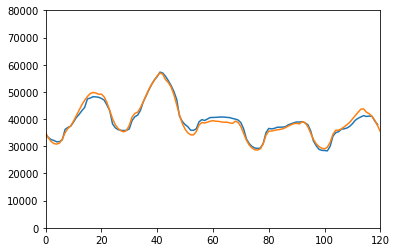

In [33]:
true_end = datetime.now().strftime('%Y%m%dT%H-%M')
true_start = pred_start.strftime('%Y%m%dT%H-%M')
series_id = 'EBA.TEX-ALL.D.HL'
true_data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, true_start, true_end))
true_usage = np.asarray(true_data.json()['series'][0]['data'])[::-1,1]
true_usage = [int(x) for x in true_usage]

plt.plot(df_pred['prediction'])
# plt.plot(df_pred['rf_pred'])
# plt.plot(df_pred['ts_pred'])

plt.plot(true_usage)
plt.ylim([0,80000])
plt.xlim([0,120])

plt.show()

In [34]:
max(df_pred['prediction'].values[48:72])

41082.96365122654

In [35]:
max(true_usage)

56994

In [36]:
for i in np.arange(96,110):
    print(df_pred['prediction'].values[i]-true_usage[i])

-572.8770309523934
-729.954428571411
-1004.8050710622556
-762.7407089132939
-601.5996611111041
-1347.7121487734512
-1455.1849698412661
-684.4869795815248
-884.4437528138733
-546.1846412698069
-98.5529944444279
-691.6284666666543
-1199.5734523809151
-1473.4367626984094


In [37]:
# Substract 2 for each temperature, 37003.685834
# original 37713.642811
# only '700' difference which is acceptable.
# houston+5 last, 48915.220417,
# original, 46309.444140,

### Beautified Plot

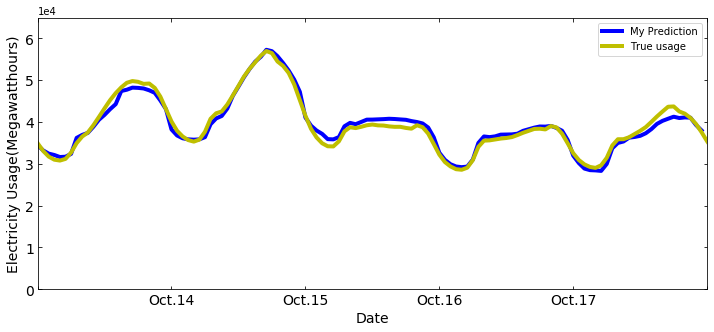

In [38]:
true_end = datetime.now().strftime('%Y%m%dT%H-%M')
true_start = pred_start.strftime('%Y%m%dT%H-%M')
series_id = 'EBA.TEX-ALL.D.HL'
true_data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, true_start, true_end))
true_usage = np.asarray(true_data.json()['series'][0]['data'])[::-1,1]
true_usage = [int(x) for x in true_usage]

fig,ax = plt.subplots(figsize=(12,5))
plt.plot(df_pred['prediction'], 'b', linewidth=4)
plt.plot(true_usage, 'y', linewidth=4)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Electricity Usage(Megawatthours)', fontsize=14)
plt.legend(['My Prediction', 'True usage'])
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xticklabels(['', '', 'Oct.14', 'Oct.15', 'Oct.16', 'Oct.17'])
plt.ylim([0,65000])
plt.xlim([0,120])

# Adjust the display style
plt.tick_params(which = 'both',top=True,right=True,direction='in')
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

plt.show()


### Produce data for the database

In [39]:
def fake_prediction(row):
    if np.isnan(row['prediction']):
        return (int(row['usage'])+int(row['net_gen']))/2
    else:
        return row['prediction']

In [40]:
sample_for_app = df_for_periodic_model.loc[df_for_periodic_model['datetime'] < datetime(2019,10,18,0,30,0), ['datetime', 'usage','net_gen']]

In [41]:
sample_for_app.loc[sample_for_app['datetime'] > datetime(2019,10,15,0,6,0),"T_1"] = houston_pred[-96:-24]
sample_for_app.loc[sample_for_app['datetime'] > datetime(2019,10,15,0,6,0),"T_2"] = dallas_pred[-96:-24]
sample_for_app.loc[sample_for_app['datetime'] > datetime(2019,10,15,0,6,0),"T_3"] = san_antonio_pred[-96:-24]


sample_for_app.loc[sample_for_app['datetime'] > datetime(2019,10,14,0,4,0),"prediction"] = df_pred.loc[df_pred['datetime'] < datetime(2019,10,18,0,30,0),"prediction"].values
sample_for_app['prediction'] = sample_for_app.apply(lambda row: fake_prediction(row), axis=1)

sample_for_app['region'] = 'TEX'
sample_for_app = sample_for_app.replace(np.nan, 0)

sample_for_app['temperatures'] = sample_for_app.apply(lambda row: ',,'.join([str(t) for t in row[['T_1','T_2','T_3']].values]), axis=1)
sample_for_app = sample_for_app[['datetime', 'usage', 'net_gen','temperatures','prediction','region']]

In [49]:
sample_for_app.dtypes

datetime        datetime64[ns]
usage                    int64
net_gen                  int64
temperatures            object
prediction             float64
region                  object
dtype: object

In [50]:
# Add 17 days to all the data and set minutes to 6
def shift(time):
    return time+timedelta(days=11)+timedelta(minutes=1)
sample_for_app['datetime'] = sample_for_app['datetime'].apply(lambda time: shift(time))

In [51]:
pd.set_option('display.max_rows',200)
sample_for_app

,datetime,usage,net_gen,temperatures,prediction,region
0,2019-10-22 00:06:00,43833,43796,"0.0,,0.0,,0.0",43814.500000,TEX
1,2019-10-22 01:06:00,40775,40703,"0.0,,0.0,,0.0",40739.000000,TEX
2,2019-10-22 02:06:00,38687,38475,"0.0,,0.0,,0.0",38581.000000,TEX
3,2019-10-22 03:06:00,37148,36931,"0.0,,0.0,,0.0",37039.500000,TEX
4,2019-10-22 04:06:00,36132,35915,"0.0,,0.0,,0.0",36023.500000,TEX
5,2019-10-22 05:06:00,35779,35562,"0.0,,0.0,,0.0",35670.500000,TEX
6,2019-10-22 06:06:00,36624,36410,"0.0,,0.0,,0.0",36517.000000,TEX
7,2019-10-22 07:06:00,38555,38561,"0.0,,0.0,,0.0",38558.000000,TEX
8,2019-10-22 08:06:00,39316,39591,"0.0,,0.0,,0.0",39453.500000,TEX
9,2019-10-22 09:06:00,39673,39955,"0.0,,0.0,,0.0",39814.000000,TEX


In [52]:
from pymongo import MongoClient

MONGODB_HOST = 'localhost'
MONGODB_PORT = 27017
DBS_NAME = 'donorschoose'
COLLECTION_NAME = 'electricity_prediction'

connection = MongoClient(MONGODB_HOST, MONGODB_PORT)
collection = connection[DBS_NAME][COLLECTION_NAME]

In [53]:
for ind, row in sample_for_app.iterrows():
    collection.insert_one({'datetime':row['datetime'],
                           'usage':int(row['usage']),
                           'temperatures':row['temperatures'],
                           'prediction':int(row['prediction']),
                           'net_gen':int(row['net_gen']),
                           'region':row['region']})

In [67]:
# Get data for Northwest
sample_for_app_NW = sample_for_app[['datetime']].copy()

In [68]:
end = datetime(2019,10,18,0,5,0).strftime('%Y%m%dT%H-%M')
start = datetime(2019,10,11,0,5,0).strftime('%Y%m%dT%H-%M')
series_id = 'EBA.TEX-ALL.NG.HL'
data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, start, end))
series_id = 'EBA.TEX-ALL.D.HL'
usage_data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, start, end))

In [69]:
sample_for_app_NW['net_gen'] = np.asarray(data.json()['series'][0]['data'])[:,1]
sample_for_app_NW['usage'] = np.asarray(usage_data.json()['series'][0]['data'])[:,1]

In [70]:
sample_for_app_NW.dtypes

datetime    datetime64[ns]
net_gen             object
usage               object
dtype: object

In [71]:
sample_for_app_NW.loc[sample_for_app_NW['datetime'] > datetime(2019,10,15,0,6,0),"T_1"] = houston_pred[-96:-24]
sample_for_app_NW.loc[sample_for_app_NW['datetime'] > datetime(2019,10,15,0,6,0),"T_2"] = dallas_pred[-96:-24]
sample_for_app_NW.loc[sample_for_app_NW['datetime'] > datetime(2019,10,15,0,6,0),"T_3"] = san_antonio_pred[-96:-24]

sample_for_app_NW['region'] = 'NW'
sample_for_app_NW = sample_for_app_NW.replace(np.nan, 0)
sample_for_app_NW['prediction'] = [np.nan]*len(sample_for_app_NW)
sample_for_app_NW['prediction'] = sample_for_app_NW.apply(lambda row: fake_prediction(row), axis=1)

sample_for_app_NW['temperatures'] = sample_for_app_NW.apply(lambda row: ',,'.join([str(t) for t in row[['T_1','T_2','T_3']].values]), axis=1)
sample_for_app_NW = sample_for_app_NW[['datetime', 'usage', 'net_gen','temperatures','prediction','region']]

In [75]:
for ind, row in sample_for_app_NW.iterrows():
    collection.insert_one({'datetime':row['datetime'],
                           'usage':int(row['usage']),
                           'temperatures':row['temperatures'],
                           'prediction':int(row['prediction']),
                           'net_gen':int(row['net_gen']),
                           'region':row['region']})

In [73]:
sample_for_app_NW.head(1)

,datetime,usage,net_gen,temperatures,prediction,region
0,2019-10-11 00:05:00,32534,32712,"0.0,,0.0,,0.0",32623.0,NW


In [74]:
sample_for_app_NW

,datetime,usage,net_gen,temperatures,prediction,region
0,2019-10-11 00:05:00,32534,32712,"0.0,,0.0,,0.0",32623.0,NW
1,2019-10-11 01:05:00,34920,35103,"0.0,,0.0,,0.0",35011.5,NW
2,2019-10-11 02:05:00,37207,37371,"0.0,,0.0,,0.0",37289.0,NW
3,2019-10-11 03:05:00,38714,38897,"0.0,,0.0,,0.0",38805.5,NW
4,2019-10-11 04:05:00,39046,39225,"0.0,,0.0,,0.0",39135.5,NW
...,...,...,...,...,...,...
164,2019-10-17 20:05:00,36132,35915,"65.0,,67.0,,68.0",36023.5,NW
165,2019-10-17 21:05:00,37148,36931,"65.0,,65.0,,67.0",37039.5,NW
166,2019-10-17 22:05:00,38687,38475,"63.0,,63.0,,65.0",38581.0,NW
167,2019-10-17 23:05:00,40775,40703,"62.0,,61.0,,64.0",40739.0,NW
